# SETUP

In [380]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import torch
from tqdm import tqdm, trange
from transformers import AutoModel
from keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

In [402]:
# GPU check
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1050 Ti


# FUNCTIONS

In [3]:
def get_embeddings_with_cpu(data_tensor, mask_tensor):
    embeddings = model.forward(input_ids=data_tensor,
        attention_mask=mask_tensor,
        head_mask=None)
    print(embeddings[0].shape)

    return embeddings[0]

In [4]:
"""
For dealing with large amounts of data, a GPU is much faster

The resulting embedding matrix is a three-dimensional tensor corresponding to                 [Sentence][Words][Embeddings]
embeddings[5][4][:] is thus the embedding of the fourth word in the fifth sentence
"""

def get_embeddings_with_gpu(data_matrix, mask_matrix):
    # Load the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(f"Using device: {torch.cuda.get_device_name(0)}")

    # Set the model to use the device
    model.cuda()

    # Move the data onto the GPU
    data_matrix = data_matrix.to(device)
    mask_matrix = mask_matrix.to(device)

    # Generate embeddings
    matrix_embedding = model.forward(input_ids=data_matrix,
        attention_mask=mask_matrix,
        head_mask=None)[0]
    #print(f"Embedding generated with shape {batch_embedding.shape}")

    # Make it an ordinary np array instead of a torch
    matrix_embedding = np.array(matrix_embedding.tolist())

    return matrix_embedding

#Keep amount of samples low to not overwhelm the gpu
#get_embeddings_with_gpu(data_tensor_matrix[:10], mask_tensor_matrix[:10])

In [5]:
"""
Most people won't be able to load all the data onto the GPU at once however, so it's better   to do it in batches.
(50 input sentences take 2803MB on my computer, for example).

This method batchifies and stitches together the batches
"""
def get_embeddings_with_gpu_batch(data_matrix, mask_matrix, batch_size):
    num_items = data_matrix.shape[0]
    num_loops = int(np.ceil(num_items/batch_size))

    start = 0
    end = batch_size
    data_holder = []

    for i in trange(num_loops):
        # Split the data into batches
        data_batch = data_matrix[start:end]
        mask_batch = mask_matrix[start:end]

        #Get the embedding for the batch
        batch_embedding = get_embeddings_with_gpu(data_batch, mask_batch)

        data_holder.append(batch_embedding)

        #Move to next batch
        start += batch_size
        end += batch_size

    # Merge the batches we've generated
    embedding_matrix = np.vstack(data_holder)

    print(f"Final embedding generated with shape {embedding_matrix.shape}")

    return embedding_matrix

#embedding_matrix = get_embeddings_with_gpu_batch(data_tensor_matrix[:200], mask_tensor_matrix[:200], 50)


In [6]:
"""
The input needs to be on the form of a dataframe with a column named 'Sentence'
Where each row consists of one sentence

One can also pass an ordinary string, this method formats it for use with the model
"""
def check_input_format(input_data):
    print("Checking input...")
    if isinstance(input_data, pd.DataFrame):
        if 'Sentence' in input_data:
            print("PASS")
            return input_data
        else:
            print("FAIL")
    elif isinstance(input_data, str):
        print("Converting sentence to DataFrame Object")
        sentence_df = pd.DataFrame()
        sentence_df['Sentence'] = [input_data]
        return sentence_df
    else:
        print("FAIL")

In [7]:
def count_unique_elements_in_2d_matrix(matrix):
    #Stop it from being a tensor
    x = np.array(matrix.tolist())
    
    #Make it 1D
    x = x.reshape(x.shape[0]*x.shape[1], )
    
    #Make it into a set
    x = set(x)
    
    #Count amount of unique elements in set
    return len(x)

In [8]:
"""
Split data into train and test sets by the given ratio.
Validation sets are not needed, those we get for free with keras models
"""
def split_data(percentage_to_train_on, input_data, output_data):
    ratio = percentage_to_train_on

    split = int(np.ceil(ratio*input_data.shape[0]))

    train_x = input_data[:split]
    train_y = output_data[:split]

    test_x = input_data[split:]
    test_y = output_data[split:]

    return train_x, train_y, test_x, test_y


# LOAD DATA

In [256]:
#This is the latest!
def load_data_from_start2():
    #Load the data
    sentences = np.load("../data/sentence_ints.npy")
    attentions = np.load("../data/attention_ints.npy")
    labels = np.load("../data/label_ints.npy")
    label_list = np.load("../data/label_list.npy")
    return sentences, attentions, labels, label_list

sentences, attentions, labels, label_list = load_data_from_start2()


In [401]:
# Load the model and tokenizer
model = AutoModel.from_pretrained('KB/albert-base-swedish-cased-alpha')
tokenizer = AutoTokenizer.from_pretrained("KB/albert-base-swedish-cased-alpha")

#Update the tokenizer with our labels (which do not exist in the normal vocabulary)
tokenizer.add_tokens(label_list.tolist())

#Inform the model that we've updated the vocab
model.resize_token_embeddings(len(tokenizer))

Embedding(50030, 128)

In [389]:
# Let's test stuff with just a subset of the data
sentences, attentions, labels = sentences[:5000], attentions[:5000], labels[:5000]

#Convert to tensors
sentences, attentions = torch.tensor(sentences), torch.tensor(attentions)

In [390]:
sentences[0]

tensor([    2,   136,   216,   544,  9085,    72,  2955,   771,  3711, 23095,
        23380, 17959, 10178,  2095,   148,  8687,   151,   112,  3548,  7242,
          115,    54, 49933,     7,   312, 27482, 21119,   615,  5851,   208,
          546,    73,  8757, 18361,    41, 16132, 13577,    50,   666, 49933,
            7, 49933,     9,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [391]:
attentions[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [400]:
# Generate embeddings
embedding_matrix = get_embeddings_with_gpu_batch(sentences, attentions, 25)

  0%|          | 0/200 [00:00<?, ?it/s]


AttributeError: 'Model' object has no attribute 'cuda'

In [134]:
#We need to one-hot encode the output labels for use with the classifier

#Flatten the label matrix
long_single_token_label_list = labels.reshape(-1,)

#one-hot encode all labels
dummy_variable_representation = pd.get_dummies(long_single_token_label_list)

#Make a dummy-variable-index => token dict for later use
dummyIndex_label_dict = {}
for i, column in enumerate(dummy_variable_representation):
    dummyIndex_label_dict[i] = tokenizer.decode(column)
    

#Reshape the one-hot encoding so we get it in the correct shape, that is, grouped on a sentence level
label_matrix = dummy_variable_representation.values.reshape(labels.shape[0], labels.shape[1], -1)

In [139]:
#Train/test split it
ratio = 0.8
train_x,train_y,test_x,test_y = split_data(ratio, embedding_matrix, label_matrix)

print(train_y.shape, test_y.shape)
print(train_x.shape, test_x.shape)

(4000, 100, 24) (1000, 100, 24)
(4000, 100, 768) (1000, 100, 768)


# TRAIN ALBERT

### Create classification layer

To ablate the fine-tuning approach, we apply the
feature-based approach by extracting the activations from one or more layers without fine-tuning
any parameters of BERT. These contextual embeddings are used as input to a randomly initialized two-layer 768-dimensional BiLSTM before
the classification layer.



In [140]:
from keras.layers import LSTM, Bidirectional, TimeDistributed, Dropout
from keras.models import Model, Input
def naive_bilstm_model():   
    #Define the input shape. Each datapoint is a sentence consisting of seqlength words, each word 784dims
    input = Input(shape=(train_x.shape[1], train_x.shape[2]))
    # Pass it through a bidirectional lstm
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(input)
            
    # add a timedistributed layer
    out = TimeDistributed(Dense(train_y.shape[2], activation="softmax"))(model)  # softmax output layer
    
    model = Model(input, out)
    
    # Compile it
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model


In [141]:
# Train the model, setting aside 10% data for validation
classifier = naive_bilstm_model()
def train_model():
    history = model.fit(
        train_x,
        train_y,
        epochs=5,
        batch_size=50,
        validation_split=0.1)
    return history

history = train_model()
print('\nhistory dict:', history.history.keys())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 200)          695200    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 24)           4824      
Total params: 700,024
Trainable params: 700,024
Non-trainable params: 0
_________________________________________________________________
None
Train on 3600 samples, validate on 400 samples
Epoch 1/5
3600/3600 [==============================] - 14s 4ms/step - loss: 0.4001 - accuracy: 0.9080 - val_loss: 0.1829 - val_accuracy: 0.9553
Epoch 2/5
3600/3600 [==============================] - 15s 4ms/step - loss: 0.1094 - accuracy: 0.9729 - val_loss: 0.1099 - val_accuracy: 0.9710
Epoch 3/5
3600/3600 [======================

### Training history

In [142]:
def create_history_df(history):
    training_df = pd.DataFrame()
    for metric in history.history.keys():
        training_df[metric] = history.history[metric]
    return training_df

history_df = create_history_df(history)

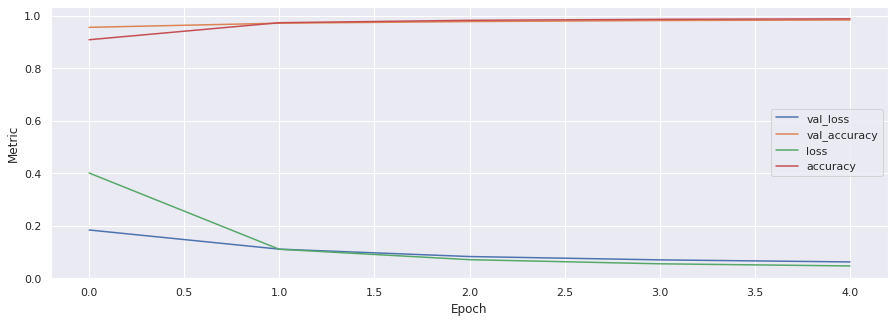

In [143]:
sns.set()
fig, ax = plt.subplots(figsize=(15,5))
history_df.plot(ax=ax)
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.show()

# Evaluation

In [257]:
print('\n# Evaluate on test data')
results = classifier.evaluate(train_x, train_y)
for i, metric in enumerate(classifier.metrics_names):
    print(f"{metric}: {results[i]}")


# Evaluate on test data
4000/4000 [==============================] - 6s 1ms/step
loss: 0.04362831270694733
accuracy: 0.9880874752998352


## Test on sentence

In [259]:
#Select a sentence
select = 999
sentence_embedding = embedding_matrix[select].reshape(1,100,-1)
sentence = np.array(sentences[select])
gt_labels = labels[select]

#For each word, obtain the probabilities for each class
prediction_probabilities = classifier.predict(sentence_embedding)[0]

#Select the one with the highest probability
p = np.argmax(prediction_probabilities, axis=-1)

#Container 
pretty_df = pd.DataFrame(columns = ['Word', 'Predicted_Label', 'True_Label', 'Certainity'])

result_container = []
for i in range(sentence.shape[0]):
    word = tokenizer.decode(int(sentence[i]))
    one_hot_index = p[i]
    certainity = prediction_probabilities[i][one_hot_index]
    predicted_label = label_dict[one_hot_index]
    gt_label = tokenizer.decode(int(gt_labels[i]))
    
    result_container. append([word, predicted_label, gt_label, certainity])
    
    #If we encounter padding, end
    if word == '<pad>':
        break;
pd.DataFrame(result_container, columns=['Word', 'Predicted_Label', 'True_Label', 'Certainity'])

,Word,Predicted_Label,True_Label,Certainity
0,[CLS],[CLS],[CLS],0.994268
1,Det,B-O,B-O,0.991493
2,var,B-O,B-O,0.995884
3,han,B-O,B-O,0.993745
4,som,B-O,B-O,0.998534
5,hade,B-O,B-O,0.998208
6,föreslagit,B-O,B-O,0.994671
7,vatten,B-O,B-O,0.980480
8,på,I-O,I-O,0.942825
9,fyll,I-O,I-O,0.980661


## Confusion Matrix

In [200]:
from keras.wrappers.scikit_learn import KerasClassifier

In [215]:
def remap(matrix):
    """
    Takes a matrix on the shape [sentence index][word index][dummy_variable_labels]
    And collapses the dummy variables into the one with the highest value
    Then remapping it to the label that corresponds to that value
    """
    
    #Switch index to label
    def switcher(x):
        return dummyIndex_label_dict[x]
    
    #Get the index along the second axis (the one-hot encoding) with the highest value
    predicted_index = pd.DataFrame(np.argmax(matrix, axis=2))
    
    #Use our dictionary to map this index to the class
    label_representation = predicted_index.applymap(switcher)

    return label_representation

In [260]:
#Get the predicted classes for the test set
prediction_probabilities = classifier.predict(test_x)

predicted_classes = remap(prediction_probabilities)
true_classes = remap(test_y)


In [261]:
# Unravel it
predicted_classes = predicted_classes.values.reshape(-1,1)
true_classes = true_classes.values.reshape(-1,1)

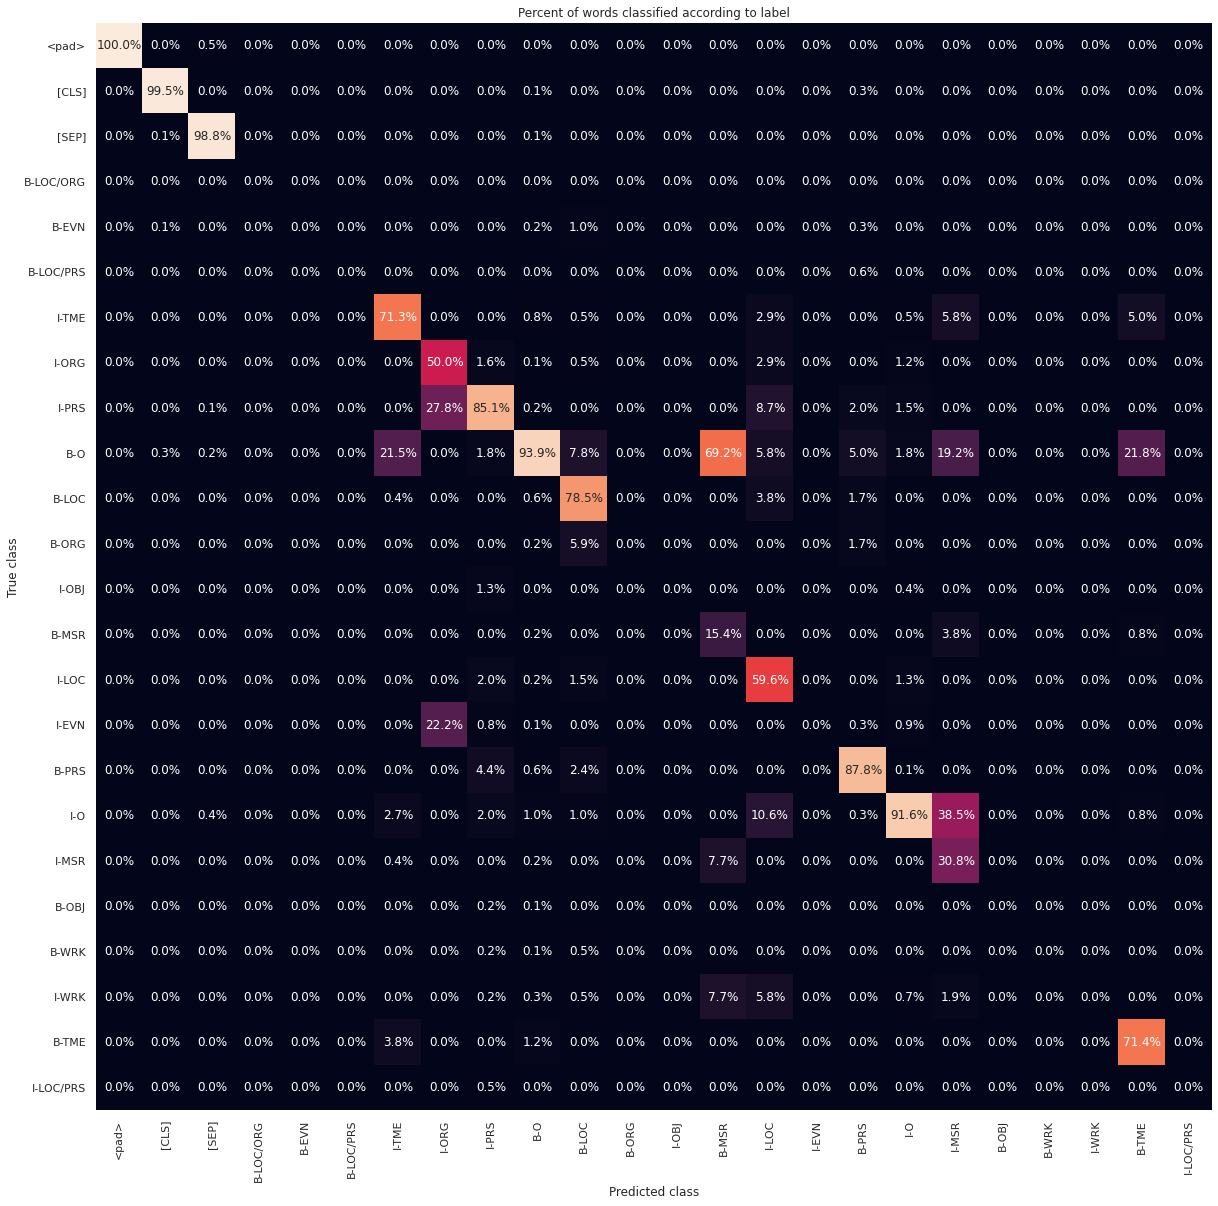

In [316]:
# The scikit confusion function also takes a list of labels. The generated confusion matrix will consist of the elements of this list, in the order they appear
labels = list(dummyIndex_label_dict.values())

# We are great at padding, but that isn't super-interesting
#labels.remove('<pad>')
#labels.remove('[CLS]')
#labels.remove('[SEP]')


#Also great at beginning of a non-entity and intermediate non-entities
#labels.remove('B-O')
#labels.remove('I-O')

#Generate a confusion matrix
cmatrix = confusion_matrix(y_true=true_classes, y_pred=predicted_classes, labels = labels)

#Use pandas for plotting purposes
cmatrix = pd.DataFrame(cmatrix, columns=labels, index=labels)

# The absolute number of things retrieved isn't as interesting as the relative retrival, so we normalize along the x-axis
cmatrix = cmatrix.apply(lambda x: x/x.sum(), axis = 0)

#Remove Nans
cmatrix = cmatrix.fillna(0)

#The confusion matrix is defined such that each row corresponds to a true label, each column is predicted label
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cmatrix, ax = ax, annot=True, fmt=".1%", cbar=False)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
plt.title("Percent of words classified according to label")
plt.show()

## Freeform sentence test

In [319]:
s = "Hi, my name is Victor! Cheers mate"

In [ ]:
def sentence_formatter(sentence, tokenizer, albert_model, classifier):
    ts = tokenizer.encode(s)
    ts = torch.tensor(ts)
    embedding = get_embeddings_with_gpu_batch(ts, attentions, 1)
    

In [317]:
sentence

array([    2,   150,    94,   138,    67,   305, 13568,  1208,  2707,
        6759,   268,    41, 27487,   121,    79, 14462,  1208, 35219,
       49933,     9,     3,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [409]:
#Create a dummy array
pad_symbol = tokenizer.encode('<pad>', add_special_tokens=False)
input_array = pad_symbol*100

# Encode our sentence
encoding = tokenizer.encode(s)

#Overwrite our dummy array
input_array[:len(encoding)] = encoding

#Adjust dimensionality, make it a tensor
input_tensor = torch.tensor(np.array(input_array).reshape(1,-1))

attention = np.array(input_array) != 0
attention_tensor = torch.tensor(attention.reshape(1,-1))

#Get the embedding
embedding = get_embeddings_with_gpu_batch(input_tensor, attention_tensor, 1)

#Use the classifier on it


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

Final embedding generated with shape (1, 100, 768)


In [411]:
embedding.shape

(1, 100, 768)

In [407]:
attention.shape

torch.Size([100])

In [405]:
embedding = get_embeddings_with_gpu_batch(input_tensor, attention, 1)


  0%|          | 0/100 [00:00<?, ?it/s]


IndexError: tuple index out of range

In [399]:
embedding = get_embeddings_with_gpu_batch(sentences, attentions, 1)


  0%|          | 0/5000 [00:00<?, ?it/s]


AttributeError: 'Model' object has no attribute 'cuda'